Model training using only images with perlin noise

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import numpy as np
import pandas as pd

from PIL import Image

from sklearn.model_selection import train_test_split

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, path: str, data: pd.DataFrame, transform=None) -> None:
        self.image_paths = np.array([path + filename for filename in data['filename'].to_numpy()])
        self.labels = data['epsilon'].to_numpy()
        self.transform = transform

    def __getitem__(self, inx: int) -> tuple:
        image_path = self.image_paths[inx]
        target = self.labels[inx]
        image = Image.open(image_path)
        image = np.array(image)
        # repeat grayscale value three times for all RGB channels
        image = np.repeat(image[..., np.newaxis], 3, -1)
        if self.transform:
            image = self.transform(image)
        target = torch.tensor(target, dtype=torch.float32)
        return image, target

    def __len__(self) -> int:
        return len(self.image_paths)

In [2]:
import torch

torch.tensor(1, dtype=torch.float32)

tensor(1.)

In [5]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [11]:
main_path = "../../data/generated/perlin/"
df1 = pd.read_csv(main_path + "parameters.csv")
df2 = pd.read_csv(main_path + "parameters_2.csv")

# concatenate the two dataframes
df = pd.concat([df1, df2], ignore_index=True)


In [12]:
train, valid = train_test_split(df, test_size=0.3, random_state=12, shuffle=True, stratify=df['epsilon'])

In [24]:
train_dataset = ImageDataset(path=main_path,
                             data=train,
                             transform=transform)
valid_dataset = ImageDataset(path=main_path,
                             data=valid,
                             transform=transform)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=0)

In [26]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
lr = 1e-4
epochs = 10
print(device)

cuda


In [27]:
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from tqdm import tqdm

In [28]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [29]:
model = models.resnet18(pretrained=True)

classifier = nn.Sequential(
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(512, 1000)
)

model.fc = classifier

c:\Users\janko\OneDrive\Pulpit\Artificial intelligence\Magisterka\topography-public\venv_torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\janko\OneDrive\Pulpit\Artificial intelligence\Magisterka\topography-public\venv_torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
optimizer = torch.optim.AdamW(params =  model.parameters(), lr=lr, eps=1e-8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.9, min_lr=1e-5)

In [31]:
min_valid_loss = np.inf
history = {'train_losses': [], 'valid_losses': []}

model.cuda()

for epoch in range(epochs):
    model.train()
    train_batch_losses = []
    for data, labels in tqdm(train_loader):
        images = data.cuda()
        targets = labels.cuda()
        outputs = model(images)
        
        loss = loss_fn(outputs, targets)

        #optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_batch_losses.append(loss.item())
    train_loss = np.sum(train_batch_losses) / len(train_batch_losses)
    history['train_losses'].append(train_loss)

    model.eval()
    fin_targets=[]
    fin_outputs=[]
    valid_batch_losses=[]
    with torch.no_grad():
        for data, labels in valid_loader:
            images = data.cuda()
            targets = labels.cuda()
            outputs = model(images)

            loss = loss_fn(outputs, targets)
            valid_batch_losses.append(loss.item())
        valid_loss = np.sum(valid_batch_losses) / len(valid_batch_losses)
        history['valid_losses'].append(valid_loss)
    
    if min_valid_loss > valid_loss:
        torch.save(model.state_dict(), '../../models/perlin/best_steel_model.pth')
        min_valid_loss = valid_loss
    
    print(f'Epoch {epoch} \t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}')
    scheduler.step(valid_loss)


    torch.save(model.state_dict(), '../../models/perlin/final_steel_model.pth')

  0%|          | 0/657 [00:00<?, ?it/s]

100%|██████████| 657/657 [02:12<00:00,  4.97it/s]


Epoch 0 		 Training Loss: 0.03387155494823788 		 Validation Loss: 0.008013680700624094


100%|██████████| 657/657 [02:14<00:00,  4.87it/s]


Epoch 1 		 Training Loss: 0.008442541144135824 		 Validation Loss: 0.007978716222932518


100%|██████████| 657/657 [02:13<00:00,  4.91it/s]


Epoch 2 		 Training Loss: 0.008262379115973448 		 Validation Loss: 0.007657403984031425


100%|██████████| 657/657 [02:13<00:00,  4.91it/s]


Epoch 3 		 Training Loss: 0.007509851412717702 		 Validation Loss: 0.006511087127906996


100%|██████████| 657/657 [02:14<00:00,  4.90it/s]


Epoch 4 		 Training Loss: 0.006666034187522664 		 Validation Loss: 0.005978251253482965


100%|██████████| 657/657 [02:14<00:00,  4.87it/s]


Epoch 5 		 Training Loss: 0.00623441577845388 		 Validation Loss: 0.00567941585108066


100%|██████████| 657/657 [02:14<00:00,  4.89it/s]


Epoch 6 		 Training Loss: 0.005949279875708107 		 Validation Loss: 0.005454330356358316


100%|██████████| 657/657 [02:13<00:00,  4.91it/s]


Epoch 7 		 Training Loss: 0.0056929694694505635 		 Validation Loss: 0.005271976386255809


100%|██████████| 657/657 [02:12<00:00,  4.95it/s]


Epoch 8 		 Training Loss: 0.005475205165179193 		 Validation Loss: 0.005154584644672939


100%|██████████| 657/657 [02:15<00:00,  4.86it/s]


Epoch 9 		 Training Loss: 0.0052769390684705795 		 Validation Loss: 0.0050286774032822276


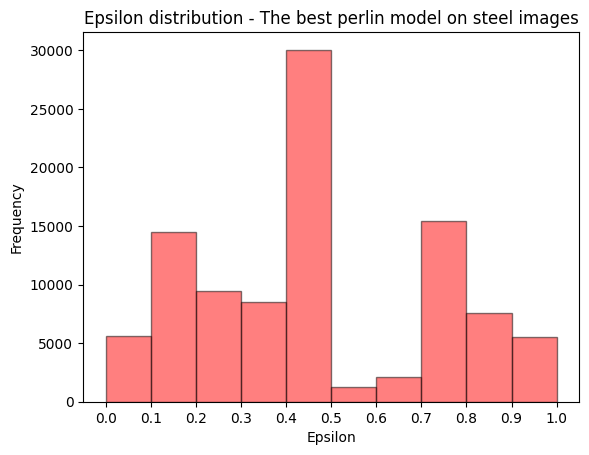

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

steel = pd.read_csv('../../data/results/perlin/best_steel_model.csv')
plt.hist(steel['epsilon'], bins=10, range=(0, 1), color='red', alpha=0.5, edgecolor='black')
plt.title('Epsilon distribution - The best perlin model on steel images')
plt.xlabel('Epsilon')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()

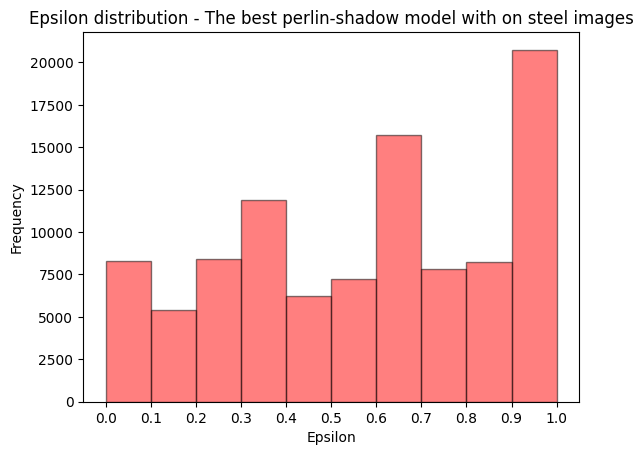

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

steel = pd.read_csv('../../data/results/perlin/fourier/best_steel_model.csv')
plt.hist(steel['epsilon'], bins=10, range=(0, 1), color='red', alpha=0.5, edgecolor='black')
plt.title('Epsilon distribution - The best perlin-shadow model with on steel images')
plt.xlabel('Epsilon')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()

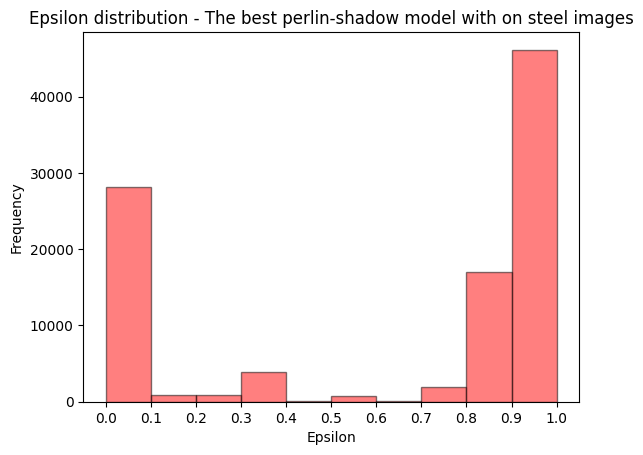

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

steel = pd.read_csv('../../data/results/perlin/fourier_basics/best_steel_model.csv')
plt.hist(steel['epsilon'], bins=10, range=(0, 1), color='red', alpha=0.5, edgecolor='black')
plt.title('Epsilon distribution - The best perlin-shadow model with on steel images')
plt.xlabel('Epsilon')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()

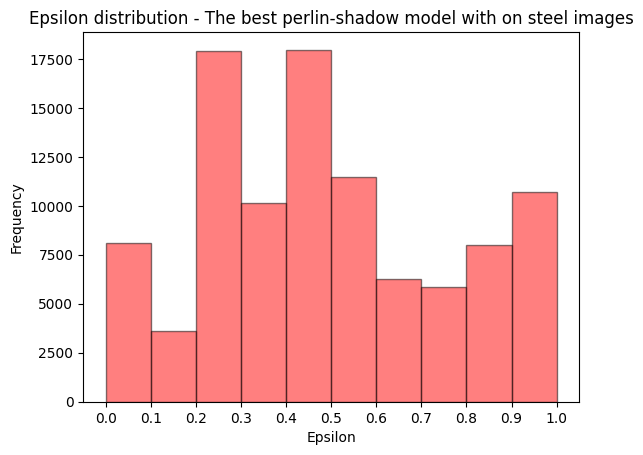

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

steel = pd.read_csv('../../data/results/perlin/ceramic/best_steel_model.csv')
plt.hist(steel['epsilon'], bins=10, range=(0, 1), color='red', alpha=0.5, edgecolor='black')
plt.title('Epsilon distribution - The best perlin-shadow model with on steel images')
plt.xlabel('Epsilon')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()

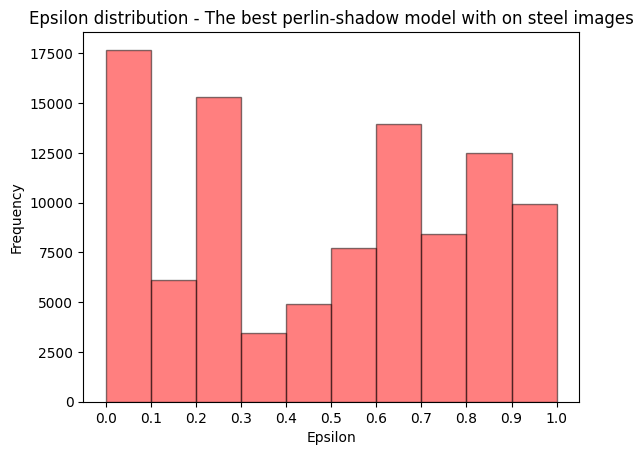

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

steel = pd.read_csv('../../data/results/perlin/ceramic_fourier/best_steel_model.csv')
plt.hist(steel['epsilon'], bins=10, range=(0, 1), color='red', alpha=0.5, edgecolor='black')
plt.title('Epsilon distribution - The best perlin-shadow model with on steel images')
plt.xlabel('Epsilon')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()

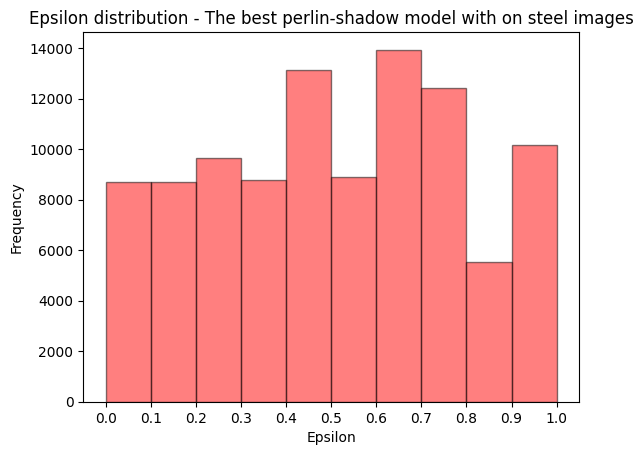

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

steel = pd.read_csv('../../data/results/perlin/moved/best_steel_model.csv')
plt.hist(steel['epsilon'], bins=10, range=(0, 1), color='red', alpha=0.5, edgecolor='black')
plt.title('Epsilon distribution - The best perlin-shadow model with on steel images')
plt.xlabel('Epsilon')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()

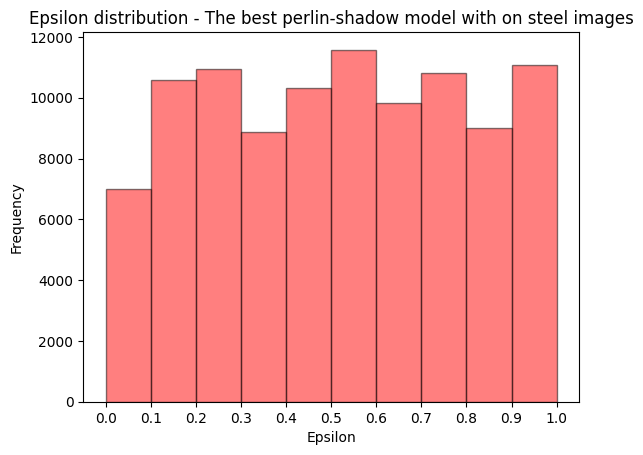

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

steel = pd.read_csv('../../data/results/perlin/moved_ceramic/best_steel_model.csv')
plt.hist(steel['epsilon'], bins=10, range=(0, 1), color='red', alpha=0.5, edgecolor='black')
plt.title('Epsilon distribution - The best perlin-shadow model with on steel images')
plt.xlabel('Epsilon')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()

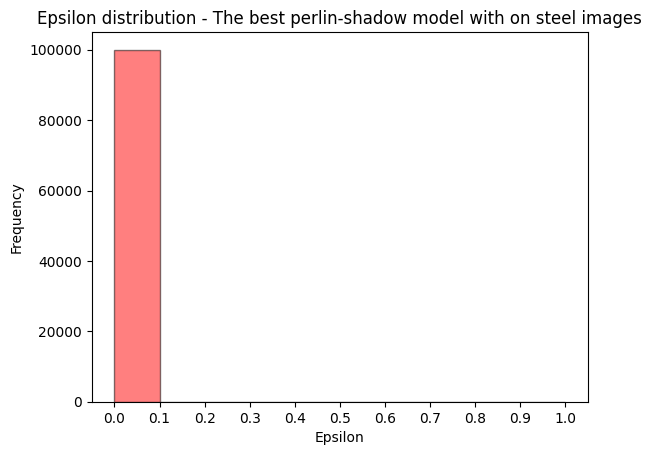

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

steel = pd.read_csv('../../data/results/perlin/moved_fourier/best_steel_model.csv')
plt.hist(steel['epsilon'], bins=10, range=(0, 1), color='red', alpha=0.5, edgecolor='black')
plt.title('Epsilon distribution - The best perlin-shadow model with on steel images')
plt.xlabel('Epsilon')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()

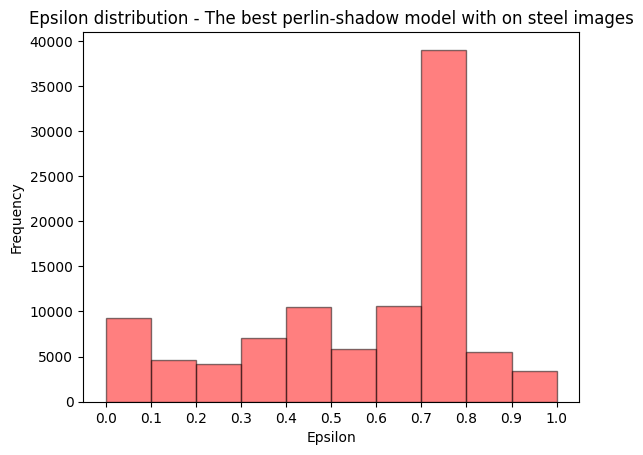

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

steel = pd.read_csv('../../data/results/perlin/moved_LARGE/best_steel_model.csv')
plt.hist(steel['epsilon'], bins=10, range=(0, 1), color='red', alpha=0.5, edgecolor='black')
plt.title('Epsilon distribution - The best perlin-shadow model with on steel images')
plt.xlabel('Epsilon')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()

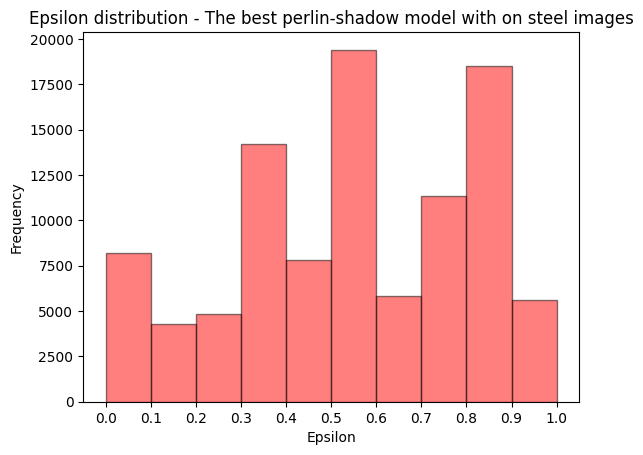

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

steel = pd.read_csv('../../data/results/perlin/moved_ceramic_avg/best_steel_model.csv')
plt.hist(steel['epsilon'], bins=10, range=(0, 1), color='red', alpha=0.5, edgecolor='black')
plt.title('Epsilon distribution - The best perlin-shadow model with on steel images')
plt.xlabel('Epsilon')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()